In [1]:
import pandas as pd

df = pd.read_csv('../assets/patient/patient_concat.csv', index_col=0)
df

,message,message_type
0,Hi,patient_greet
1,Hello,patient_greet
2,Hey there,patient_greet
3,Good morning,patient_greet
4,Good afternoon,patient_greet
...,...,...
450,"Unfortunately, I have a conflicting schedule.",patient_rejection
451,"Sorry, that time doesn't suit my availability.",patient_rejection
452,I need to cancel as I have another appointment.,patient_rejection
453,"Unfortunately, I won't be available at that time.",patient_rejection


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import joblib

tfidf_vectorizer = TfidfVectorizer(lowercase=True)

X_full = df['message'].sort_index().values
y_full = df['message_type'].sort_index().values
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['message_type'], test_size=0.2, random_state=42)

message_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [6]:
nb_classifier = MultinomialNB()
nb_classifier.fit(message_tfidf, y_train)

print('MultinomialNB score:', nb_classifier.score(tfidf_vectorizer.transform(X_test), y_test))

message_tfidf = tfidf_vectorizer.fit_transform(X_full)
nb_classifier.fit(message_tfidf, y_full)

joblib.dump(tfidf_vectorizer, '../assets/vectorizer.joblib')   
joblib.dump(nb_classifier, '../assets/nb_model.joblib')

MultinomialNB score: 0.9560439560439561


['../assets/nb_model.joblib']

In [11]:
from sklearn import metrics
y_pred = nb_classifier.predict(tfidf_vectorizer.transform(X_test))
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='weighted')
recall = metrics.recall_score(y_test, y_pred, average='weighted')
f1_score = metrics.f1_score(y_test, y_pred, average='weighted')

print("accuracy:", accuracy)
print("precision:", precision)
print("recall:", recall)
print("f1 Score:", f1_score)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:")
print(confusion_matrix)


accuracy: 1.0
precision: 1.0
recall: 1.0
f1 Score: 1.0
confusion Matrix:
[[21  0  0  0]
 [ 0 27  0  0]
 [ 0  0 24  0]
 [ 0  0  0 19]]


In [10]:
report = metrics.classification_report(y_test, y_pred)

print(report)

                      precision    recall  f1-score   support

patient_confirmation       1.00      1.00      1.00        21
       patient_greet       1.00      1.00      1.00        27
       patient_issue       1.00      1.00      1.00        24
   patient_rejection       1.00      1.00      1.00        19

            accuracy                           1.00        91
           macro avg       1.00      1.00      1.00        91
        weighted avg       1.00      1.00      1.00        91


In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, cohen_kappa_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score, KFold
import joblib
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
print("Cohen's Kappa:", kappa)
print("Matthews Correlation Coefficient:", mcc)
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]}
grid_search = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(message_tfidf, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(MultinomialNB(), message_tfidf, y_train, cv=kf, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[21  0  0  0]
 [ 0 27  0  0]
 [ 0  0 24  0]
 [ 0  0  0 19]]
Classification Report:
                      precision    recall  f1-score   support

patient_confirmation       1.00      1.00      1.00        21
       patient_greet       1.00      1.00      1.00        27
       patient_issue       1.00      1.00      1.00        24
   patient_rejection       1.00      1.00      1.00        19

            accuracy                           1.00        91
           macro avg       1.00      1.00      1.00        91
        weighted avg       1.00      1.00      1.00        91

Cohen's Kappa: 1.0
Matthews Correlation Coefficient: 1.0
Best Parameters: {'alpha': 0.1}
Best Score: 0.9917808219178081
Cross-Validation Scores: [0.94520548 0.94520548 0.95890411 0.97260274 0.93055556]
Mean Cross-Validation Score: 0.9504946727549466


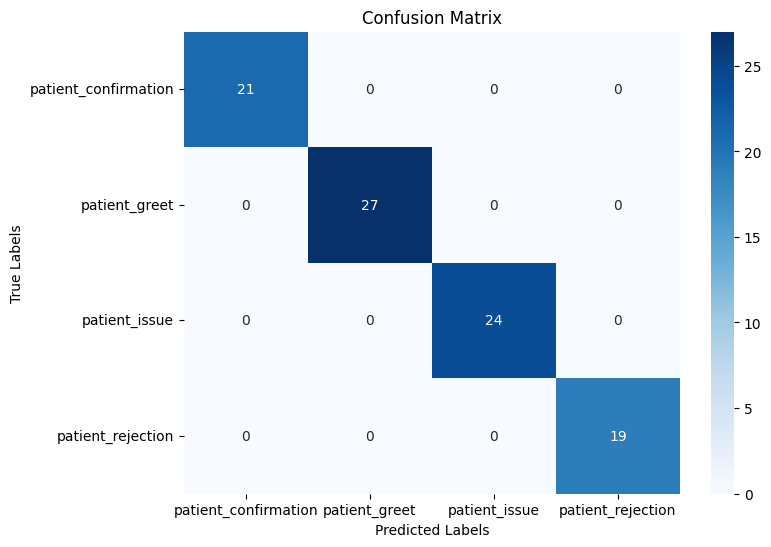

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

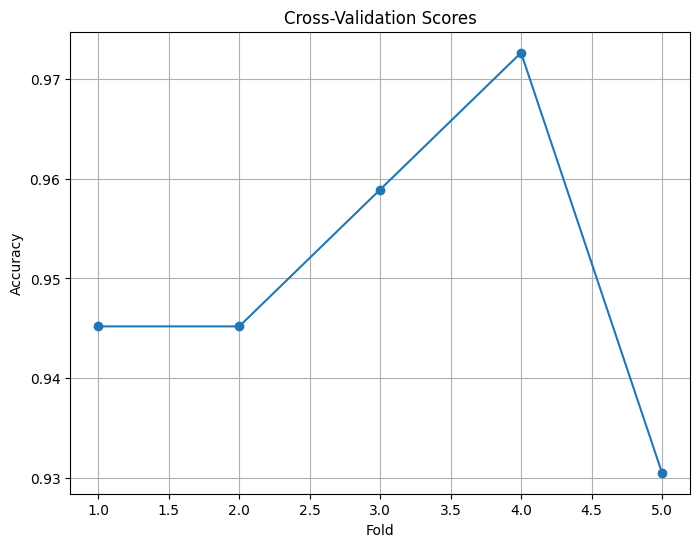

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Scores')
plt.grid(True)
plt.show()

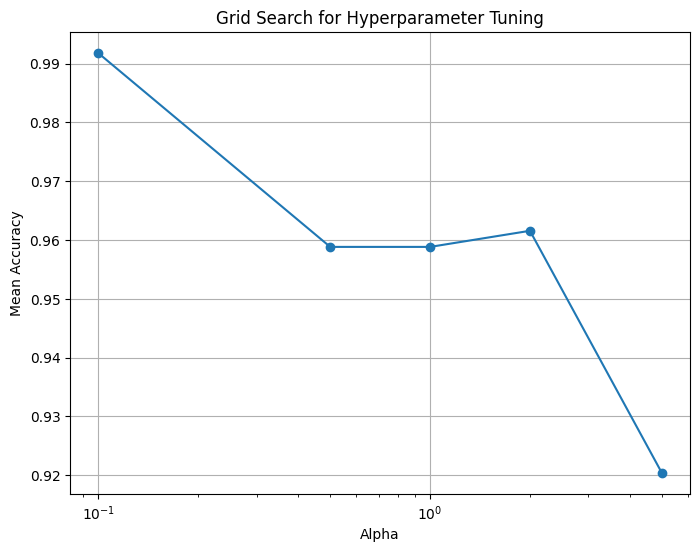

In [21]:
import numpy as np
alphas = [x['alpha'] for x in grid_search.cv_results_['params']]
mean_scores = grid_search.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.plot(alphas, mean_scores, marker='o', linestyle='-')
plt.xlabel('Alpha')
plt.ylabel('Mean Accuracy')
plt.title('Grid Search for Hyperparameter Tuning')
plt.xscale('log') 
plt.grid(True)
plt.show()